In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=False)

In [3]:
import sys

from ethp2psim.experiments import (
    extract_config_columns,
    prepare_results_for_visualization,
)

In [4]:
def filter_estimator(
    df: pd.DataFrame, value: str, col: str = "estimator"
) -> pd.DataFrame:
    return df[df[col] == value].copy()


def load_results(fname, only_first_sent=False):
    df = pd.read_csv(fname)
    if "goerli" in fname:
        df["graph_model"] = "goerli_testnet"
    else:
        df["graph_model"] = "random_regular"
    if "active_adversary" in fname:
        df["adversary_type"] = "active"
    else:
        df["adversary_type"] = "passive"
    if "degree" in fname:
        df["adversary_centrality"] = "degree"
    else:
        df["adversary_centrality"] = "none"
    if "bc_all" in fname:
        df["broadcast_mode"] = "all"
    else:
        df["broadcast_mode"] = "sqrt"
    print(df.shape)
    # shorten protocol names before visualization
    df = extract_config_columns(df)
    if only_first_sent:
        df = filter_estimator(df, "first_sent")
    print(df.shape)
    return df


def update_figure(fig, width=1300, height=1000):
    fig.update_layout(
        # TODO: it does not work in case of facet_col.. fix it!
        #    xaxis = dict(
        #        tickmode = 'linear',
        #        tick0 = 0.0,
        #        dtick = 0.05
        #    ),
        width=width,
        height=height,
    )
    fig.update_layout(
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0.0)
    )

In [5]:
experiment_dir = "../scripts/third_round_results/"
figures_dir = "../figures/"
rewrite_fig = True

# 1. Results with passive adversary

In [6]:
passive_random_df = load_results(
    "%s/random_regular_1000_none_with_dandelions.csv" % experiment_dir
)

(320, 15)
(320, 16)


In [7]:
passive_goerli_df = load_results(
    "%s/goerli_none_with_dandelions.csv" % experiment_dir, only_first_sent=True
)

(320, 15)
(160, 16)


## i.) Estimator comparison: first reach vs. first sent

- random regular graph with 1000 nodes and 50 degree
- 5% of all nodes send messages (~ number of messages)

In [8]:
passive_random_results = prepare_results_for_visualization(passive_random_df)

### Observations (only sanity check)

- Adversary is more efficient with higher adversary ratio - **OK**
- Adversary can better deanonymize simple Broadcast than Dandelion(++) - **OK**
- Dandelion and Dandelion++ has comparable results with the same broadcast probability - **OK**
- Average message spread ratio (fraction of nodes receiving each message) is 1.0 despite the protocol - **OK**
- Note that **inverse_rank and NDCG** are better metrics than hit_ratio or entropy (see next fig.) It is shocking that for these metrics Broadcast and Dandelion protocols are much closer to each other than for hit_ratio!

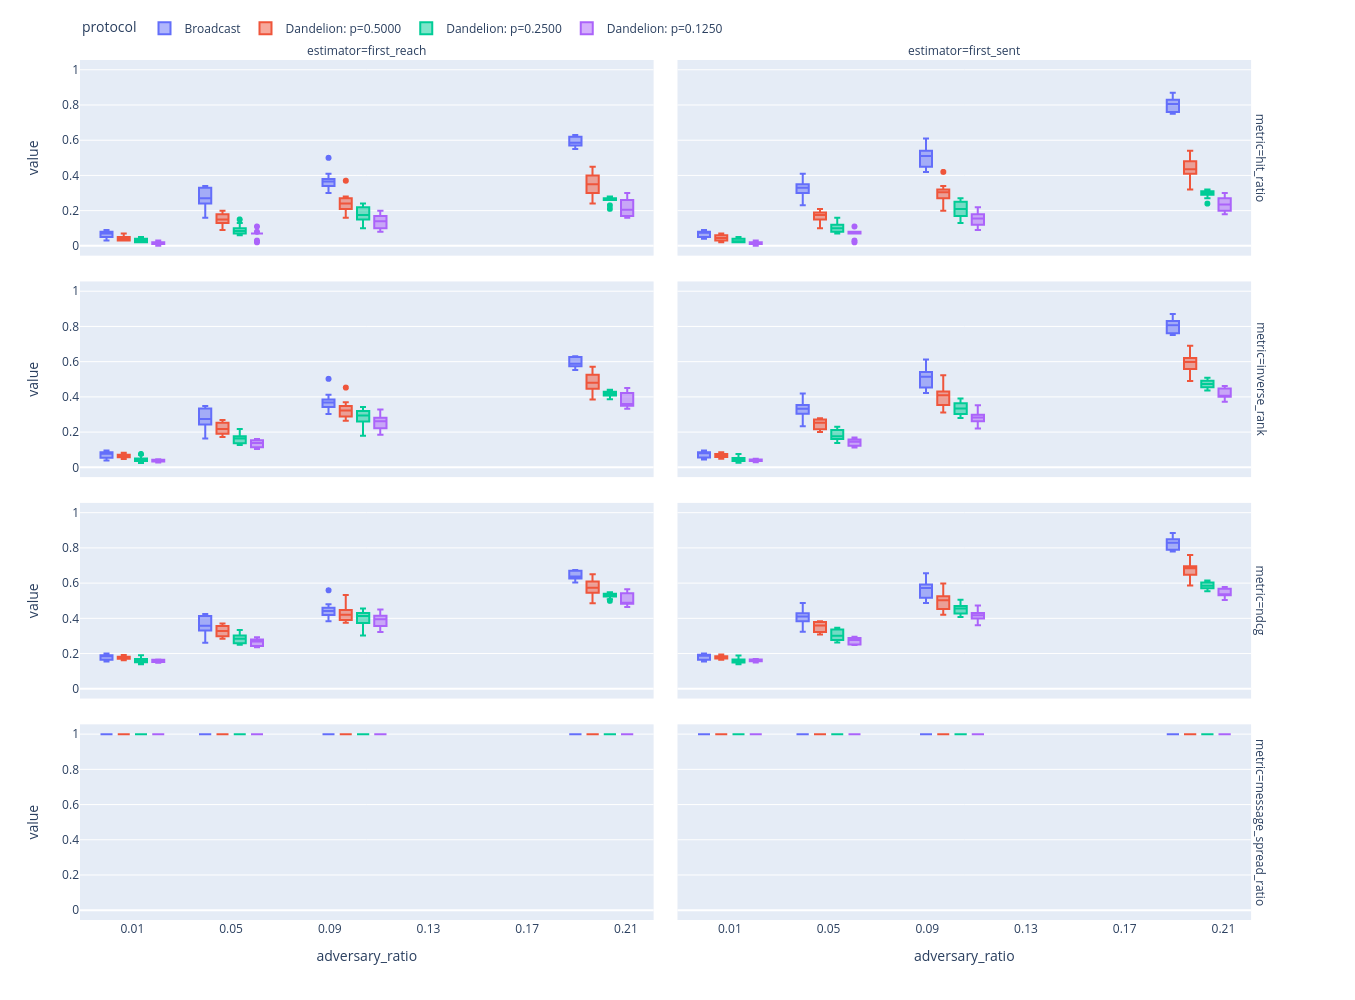

In [9]:
fig = px.box(
    passive_random_results[passive_random_results["metric"] != "entropy"],
    x="adversary_ratio",
    y="value",
    color="protocol",
    facet_col="estimator",
    facet_row="metric",
)
update_figure(fig)
if rewrite_fig:
    fig.write_image("%s/passive_estimator_check.png" % figures_dir)
fig.show()

**Entropy is a bad metric:** it does not take into account the ground truth! there is no difference for Dandelion adversary using the first reach or first send estimator...

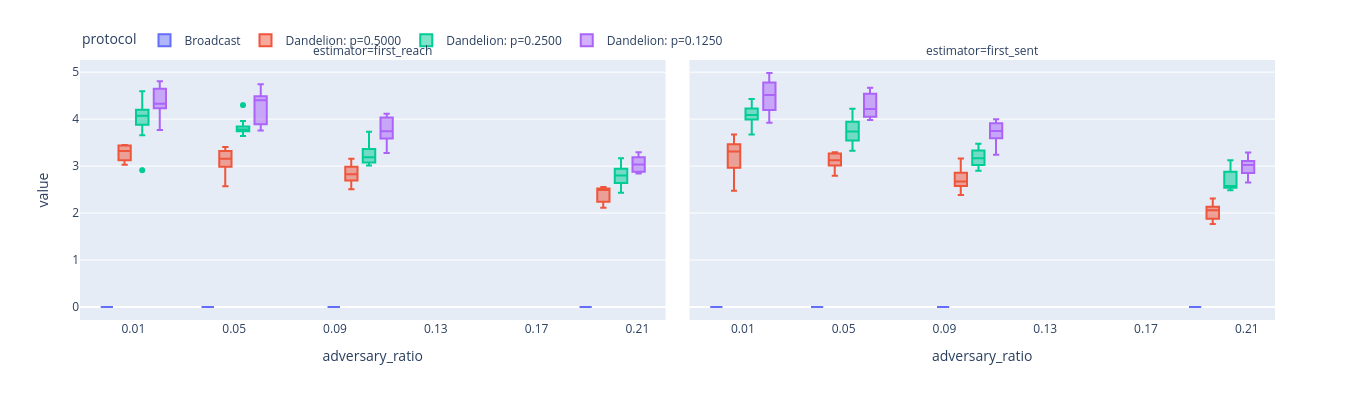

In [10]:
fig = px.box(
    passive_random_results[passive_random_results["metric"] == "entropy"],
    x="adversary_ratio",
    y="value",
    color="protocol",
    facet_col="estimator",
)
update_figure(fig, height=400)
if rewrite_fig:
    fig.write_image("%s/passive_estimator_entropy.png" % figures_dir)
fig.show()

# NOTE: from now on only first sent estimator results are shown!

## ii.) Graph model comparison: random regular vs. Goerli testnet

- Goerli testnet has approximately 1,5K nodes and 20K edges
- 10% of all nodes send messages (~ number of messages)

In [11]:
passive_goerli_results = prepare_results_for_visualization(passive_goerli_df)

In [12]:
passive_first_sent_results = pd.concat(
    [
        filter_estimator(passive_random_results, "first_sent"),
        passive_goerli_results,
    ]
)

### a.) Observations with random adversary sampling (meaningful results)

- Adversary ratio and protocol parameters trend are similar - **OK**
- In general, adversary is less effective for the Goerli testnet than for random regular graphs - **Interesting**
- Dandelion results have smaller deviation (because we use the same network structure 10 times) - **OK**
- Average message spread ratio (fraction of nodes receiving each message) is 1.0 for random regular **BUT** ~0.92 for goerli - **is it OK?** I think yes. Later we show that with broadcasting to all neighbors in the goerli network 1.0 message spread can be achieved

In [13]:
fig = px.box(
    passive_first_sent_results[passive_first_sent_results["metric"] != "entropy"],
    x="adversary_ratio",
    y="value",
    color="protocol",
    facet_col="graph_model",
    facet_row="metric",
)
update_figure(fig)
if rewrite_fig:
    fig.write_image("%s/graph_model_comparision.png" % figures_dir)
fig.show()

### b.) Observations with central node selection (meaningful results)

In [14]:
passive_random_degree_df = load_results(
    "%s/random_regular_1000_degree_with_dandelions.csv" % experiment_dir,
    only_first_sent=True,
)

(320, 15)
(160, 16)


In [15]:
passive_goerli_degree_df = load_results(
    "%s/goerli_degree_with_dandelions.csv" % experiment_dir, only_first_sent=True
)

(320, 15)
(160, 16)


In [16]:
passive_random_degree_results = prepare_results_for_visualization(
    passive_random_degree_df
)
passive_goerli_degree_results = prepare_results_for_visualization(
    passive_goerli_degree_df
)

In [17]:
passive_degree_results = pd.concat(
    [
        filter_estimator(passive_random_results, "first_sent"),
        passive_goerli_results,
        passive_random_degree_results,
        passive_goerli_degree_results,
    ]
)

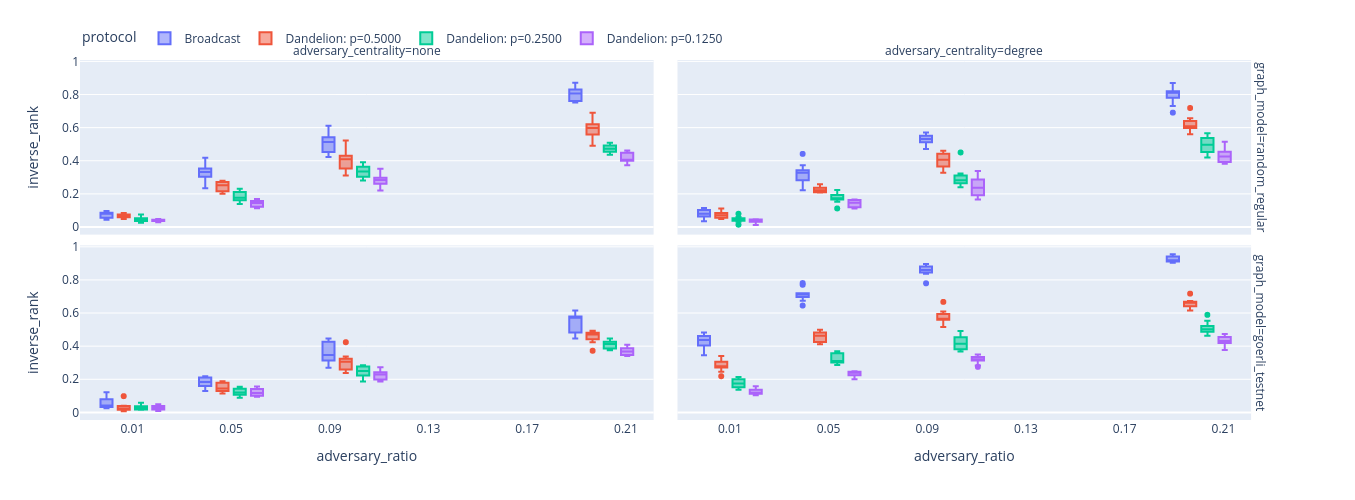

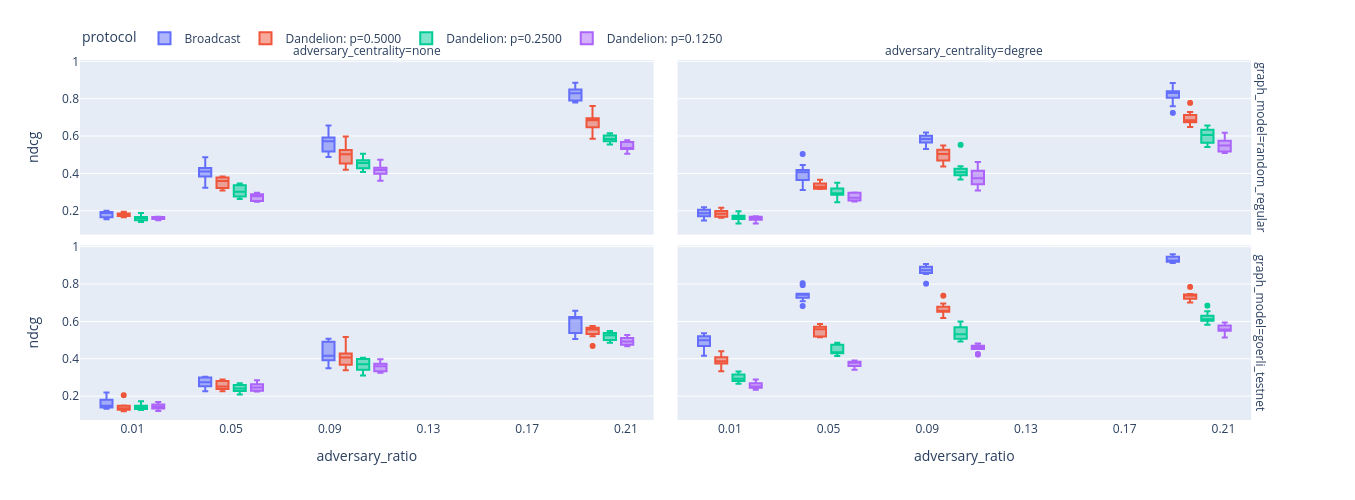

In [18]:
for metric in ["hit_ratio", "inverse_rank", "ndcg"]:
    fig = px.box(
        passive_degree_results[passive_degree_results["metric"] == metric],
        x="adversary_ratio",
        y="value",
        color="protocol",
        facet_col="adversary_centrality",
        facet_row="graph_model",
        labels={"value": metric},
    )
    update_figure(fig, 1200, 500)
    if rewrite_fig:
        fig.write_image(
            "%s/passive_adversary_centrality_%s.png" % (figures_dir, metric)
        )
    fig.show()

## iii.) Broadcast to all nodes (instead of sqrt amount of them)

In [19]:
passive_random_bc_all_df = load_results(
    "%s/random_regular_1000_none_with_dandelions_bc_all.csv" % experiment_dir,
    only_first_sent=True,
)

(320, 15)
(160, 16)


In [20]:
passive_goerli_bc_all_df = load_results(
    "%s/goerli_none_with_dandelions_bc_all.csv" % experiment_dir, only_first_sent=True
)

(320, 15)
(160, 16)


In [21]:
passive_random_bc_all_results = prepare_results_for_visualization(
    passive_random_bc_all_df
)
passive_goerli_bc_all_results = prepare_results_for_visualization(
    passive_goerli_bc_all_df
)

In [22]:
passive_broadcast_results = pd.concat(
    [
        filter_estimator(passive_random_results, "first_sent"),
        passive_goerli_results,
        passive_random_bc_all_results,
        passive_goerli_bc_all_results,
    ]
)

### Observations (meaningful results)

- Adversary can better deanonymize if message is sent to all neighbors - **OK**

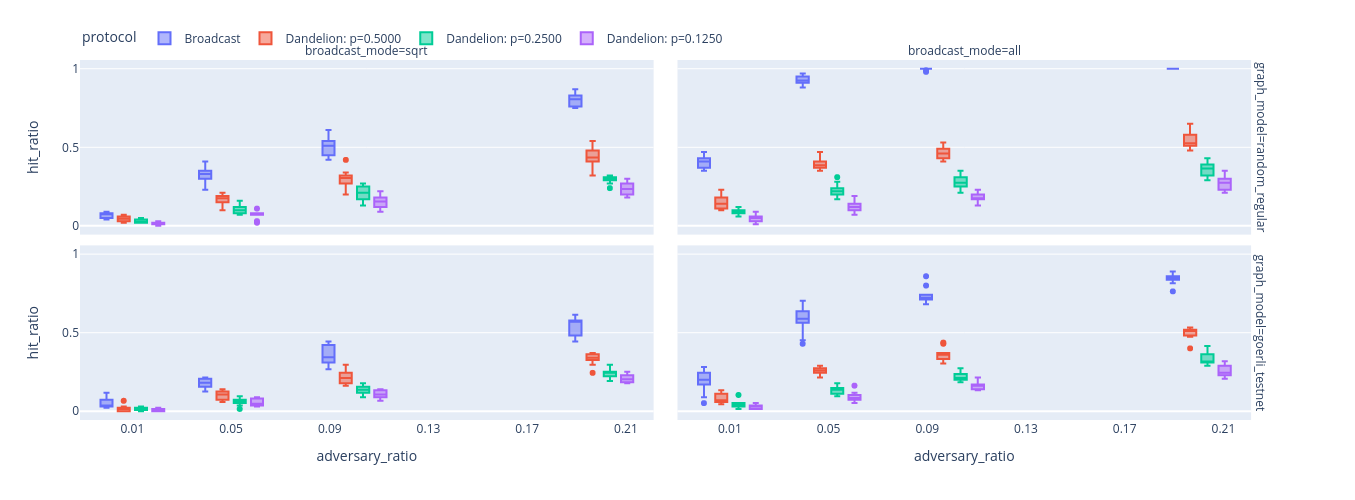

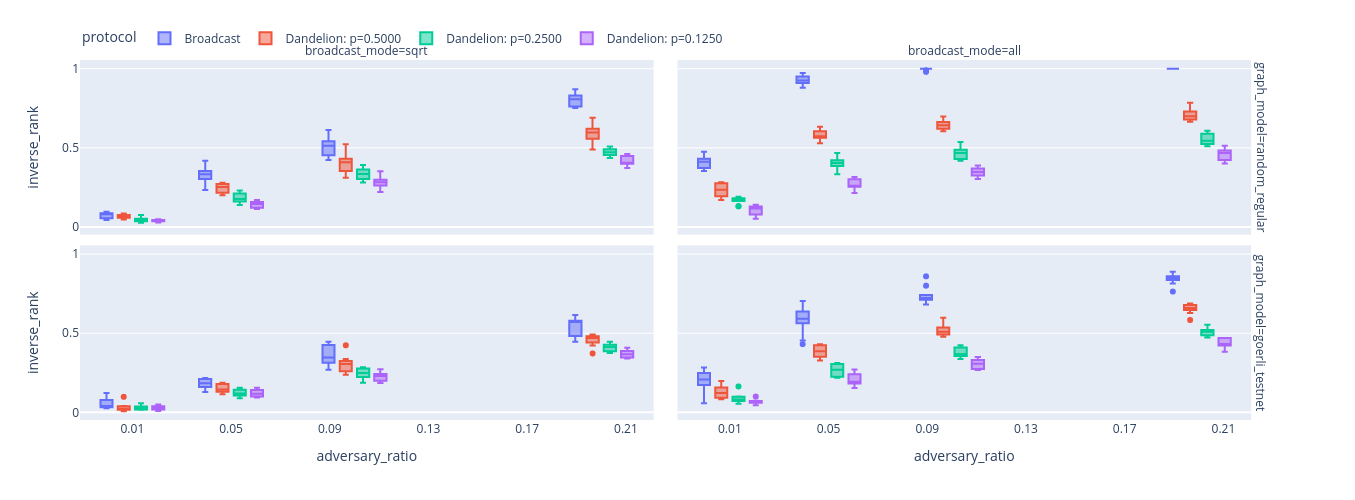

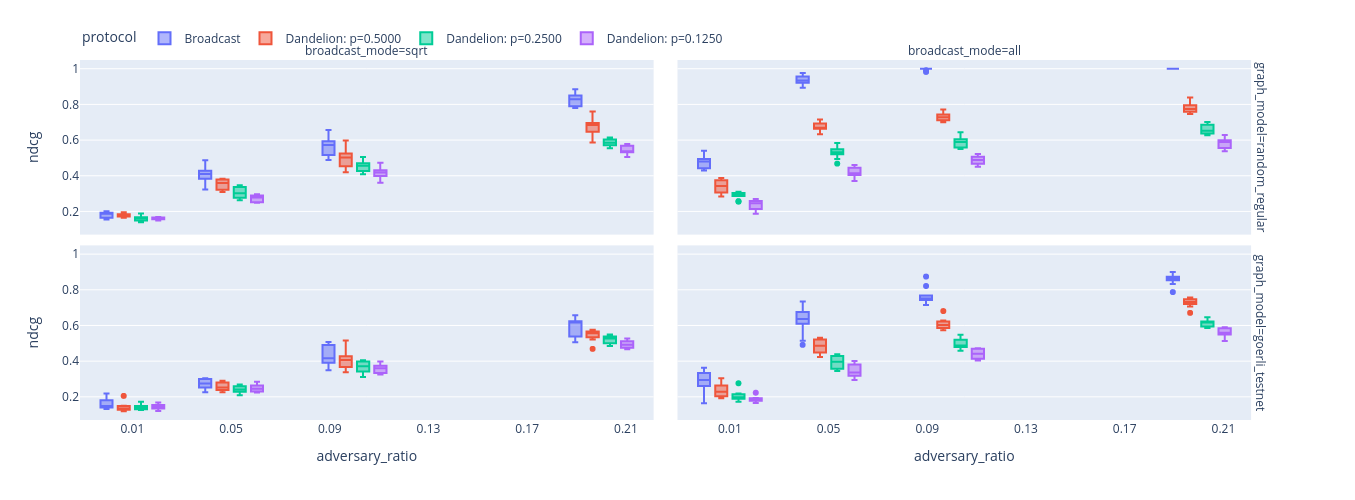

In [23]:
for metric in ["hit_ratio", "inverse_rank", "ndcg"]:
    fig = px.box(
        passive_broadcast_results[passive_broadcast_results["metric"] == metric],
        x="adversary_ratio",
        y="value",
        color="protocol",
        facet_col="broadcast_mode",
        facet_row="graph_model",
        labels={"value": metric},
    )
    update_figure(fig, 1200, 500)
    if rewrite_fig:
        fig.write_image("%s/broadcast_mode_%s.png" % (figures_dir, metric))
    fig.show()

- message spread for goerli is less in case of broadcasting to sqrt neighbors - **OK**

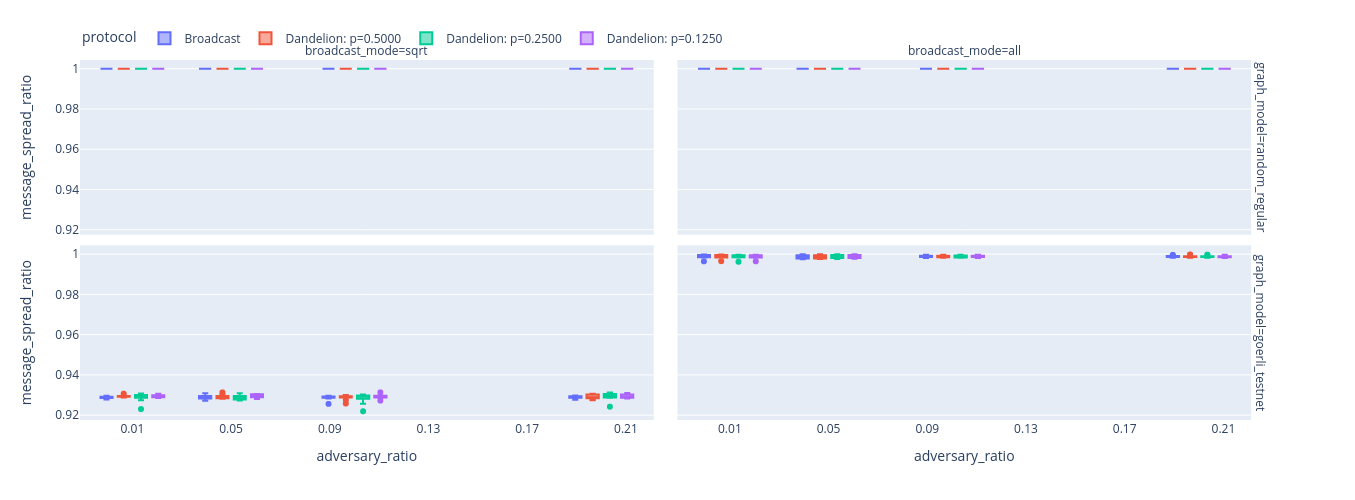

In [24]:
fig = px.box(
    passive_broadcast_results[
        passive_broadcast_results["metric"] == "message_spread_ratio"
    ],
    x="adversary_ratio",
    y="value",
    color="protocol",
    facet_col="broadcast_mode",
    facet_row="graph_model",
    labels={"value": "message_spread_ratio"},
)
update_figure(fig, 1200, 500)
if rewrite_fig:
    fig.write_image("%s/broadcast_mode_message_spread.png" % figures_dir)
fig.show()

# 2. Active vs. passive adversary

In [25]:
active_random_df = load_results(
    "%s/random_regular_1000_none_with_dandelions_active_adversary.csv" % experiment_dir,
    only_first_sent=True,
)
active_random_degree_df = load_results(
    "%s/random_regular_1000_degree_with_dandelions_active_adversary.csv"
    % experiment_dir,
    only_first_sent=True,
)

(320, 15)
(160, 16)
(320, 15)
(160, 16)


In [26]:
active_goerli_df = load_results(
    "%s/goerli_none_with_dandelions_active_adversary.csv" % experiment_dir,
    only_first_sent=True,
)
active_goerli_degree_df = load_results(
    "%s/goerli_degree_with_dandelions_active_adversary.csv" % experiment_dir,
    only_first_sent=True,
)

(320, 15)
(160, 16)
(320, 15)
(160, 16)


In [27]:
active_random_results = prepare_results_for_visualization(active_random_df)
active_goerli_results = prepare_results_for_visualization(active_goerli_df)
active_random_degree_results = prepare_results_for_visualization(
    active_random_degree_df
)
active_goerli_degree_results = prepare_results_for_visualization(
    active_goerli_degree_df
)

In [28]:
passive_active_results = pd.concat(
    [
        filter_estimator(passive_random_results, "first_sent"),
        passive_goerli_results,
        active_random_results,
        active_goerli_results,
    ]
)

In [29]:
passive_active_degree_results = pd.concat(
    [
        active_random_results,
        active_goerli_results,
        active_random_degree_results,
        active_goerli_degree_results,
    ]
)

### Observations (meaningful)

- Active adversary effect on message spread behaves as expected - **OK**

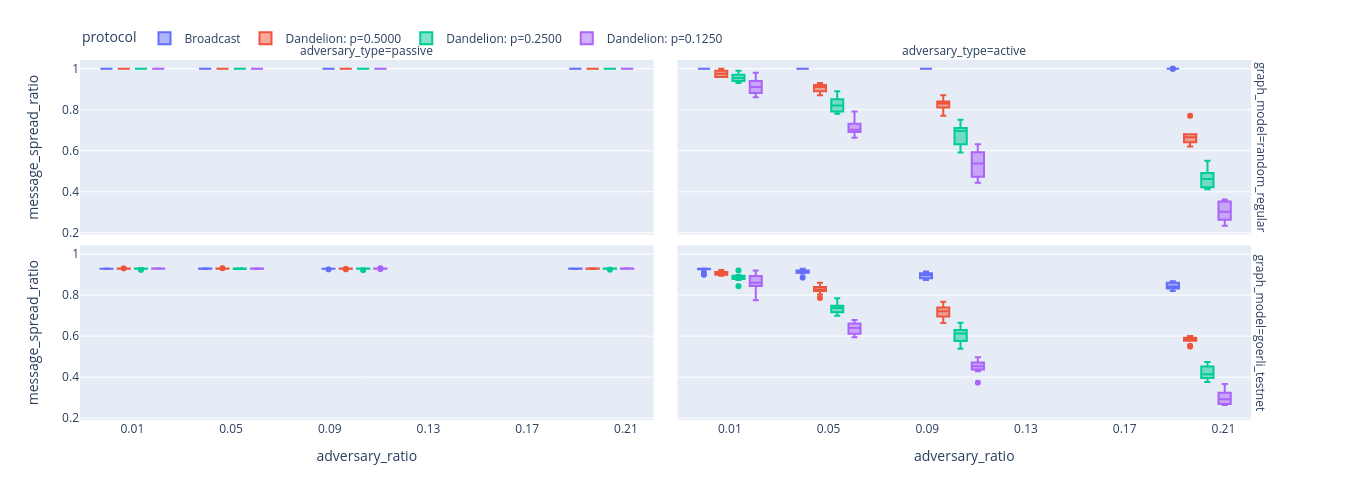

In [30]:
fig = px.box(
    passive_active_results[passive_active_results["metric"] == "message_spread_ratio"],
    x="adversary_ratio",
    y="value",
    color="protocol",
    facet_col="adversary_type",
    facet_row="graph_model",
    labels={"value": "message_spread_ratio"},
)
update_figure(fig, 1200, 500)
if rewrite_fig:
    fig.write_image("%s/passive_vs_active_adversary_message_spread.png" % figures_dir)
fig.show()

* and it is even worse if adversaries are high centrality nodes

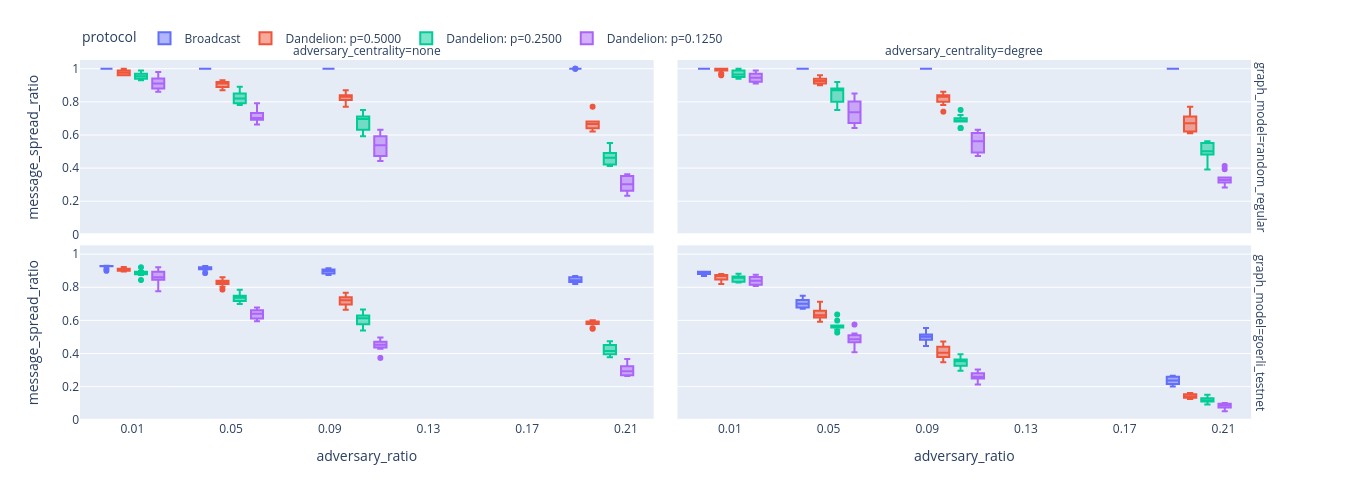

In [31]:
fig = px.box(
    passive_active_degree_results[
        passive_active_degree_results["metric"] == "message_spread_ratio"
    ],
    x="adversary_ratio",
    y="value",
    color="protocol",
    facet_col="adversary_centrality",
    facet_row="graph_model",
    labels={"value": "message_spread_ratio"},
)
update_figure(fig, 1200, 500)
if rewrite_fig:
    fig.write_image(
        "%s/passive_vs_active_adversary_centrality_message_spread.png" % figures_dir
    )
fig.show()

- There is no significant difference in adversary performance **(as expected)**

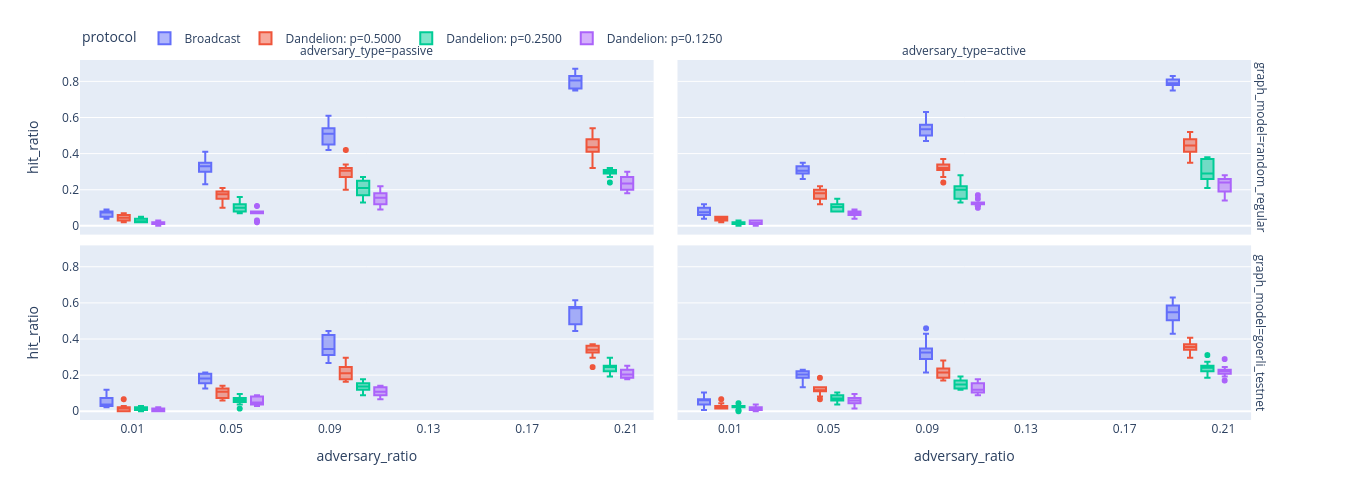

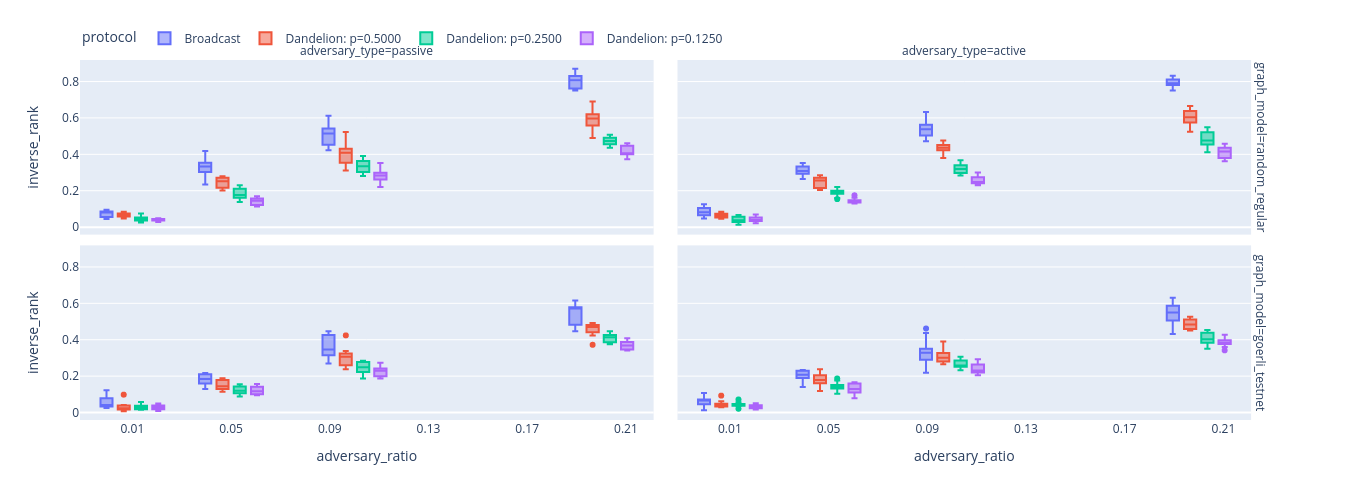

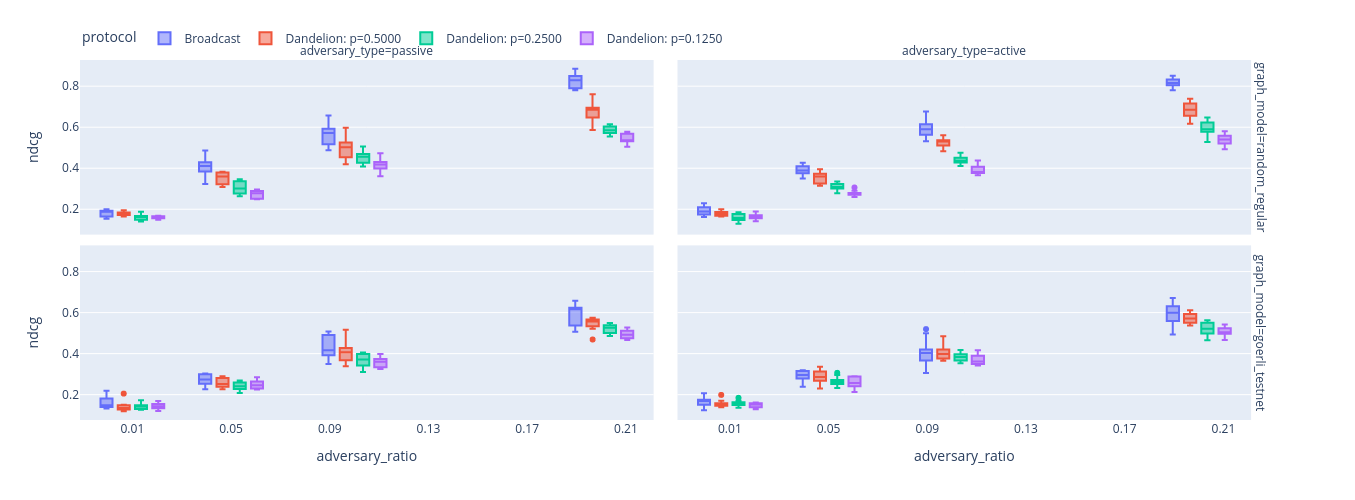

In [32]:
for metric in ["hit_ratio", "inverse_rank", "ndcg"]:
    fig = px.box(
        passive_active_results[passive_active_results["metric"] == metric],
        x="adversary_ratio",
        y="value",
        color="protocol",
        facet_col="adversary_type",
        facet_row="graph_model",
        labels={"value": metric},
    )
    update_figure(fig, 1200, 500)
    if rewrite_fig:
        fig.write_image("%s/passive_vs_active_adversary_%s.png" % (figures_dir, metric))
    fig.show()

# Node contact time cexperiments

In [33]:
def extract_contact_time_quantiles(
    dataframe, group_cols=["protocol"], target_col="mean_contact_time_quantiles"
):
    df = dataframe.copy()
    df[target_col] = df[target_col].apply(eval)
    mean_time_q_aggr = (
        filter_estimator(df, "first_sent")
        .groupby(group_cols)[target_col]
        .sum()
        .reset_index()
    )
    # print(mean_time_q_aggr.head())
    mean_time_q_aggr[target_col] = mean_time_q_aggr[target_col].apply(
        lambda x: np.mean(np.array(x).reshape(-1, 9), axis=0)
    )
    old_cols = set(mean_time_q_aggr.columns)
    mean_time_q_aggr = mean_time_q_aggr.assign(
        **pd.DataFrame(mean_time_q_aggr[target_col].values.tolist()).add_prefix("q_")
    )
    diff_cols = sorted(list(set(mean_time_q_aggr.columns).difference(old_cols)))
    visu_df = mean_time_q_aggr.melt(
        id_vars=group_cols, value_vars=diff_cols, value_name="time", var_name="quantile"
    )
    replace_map = dict(zip(diff_cols, np.arange(0.1, 1.1, 0.1)))
    visu_df["quantile"] = visu_df["quantile"].replace(replace_map)
    return visu_df

### Nodes are reached slower on the Goerli testnet than on random regular graph - **OK** (Goerli is larger)

In [34]:
visu1 = extract_contact_time_quantiles(passive_random_df)
visu1["graph_model"] = "random_regular"
visu2 = extract_contact_time_quantiles(passive_goerli_df)
visu2["graph_model"] = "goerli_testnet"
visu_df = pd.concat([visu1, visu2])

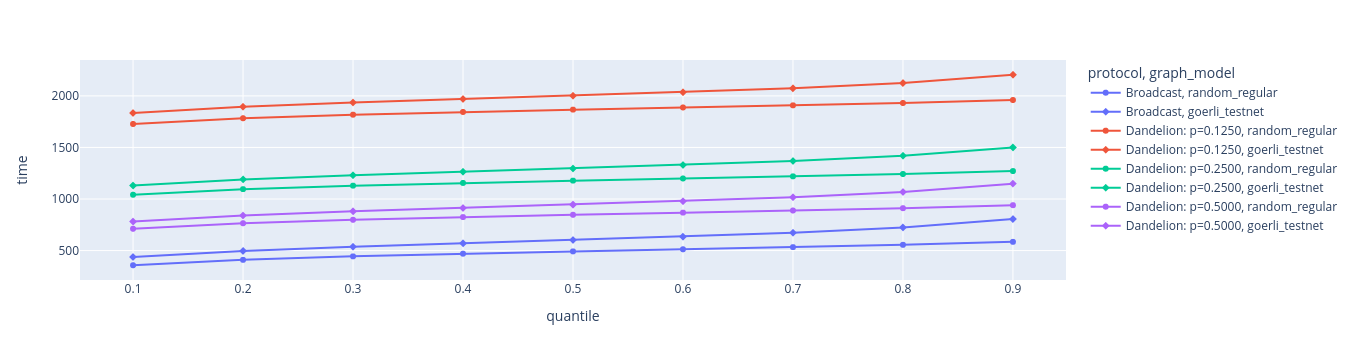

In [35]:
fig = px.line(visu_df, x="quantile", y="time", color="protocol", symbol="graph_model")
fig.show()

### Nodes are reached slower in case of "sqrt" boradcast setting - **OK**

In [36]:
visu1 = extract_contact_time_quantiles(passive_random_bc_all_df)
visu1["broadcast_mode"] = "all"
visu2 = extract_contact_time_quantiles(passive_random_df)
visu2["broadcast_mode"] = "sqrt"
visu_df = pd.concat([visu1, visu2])

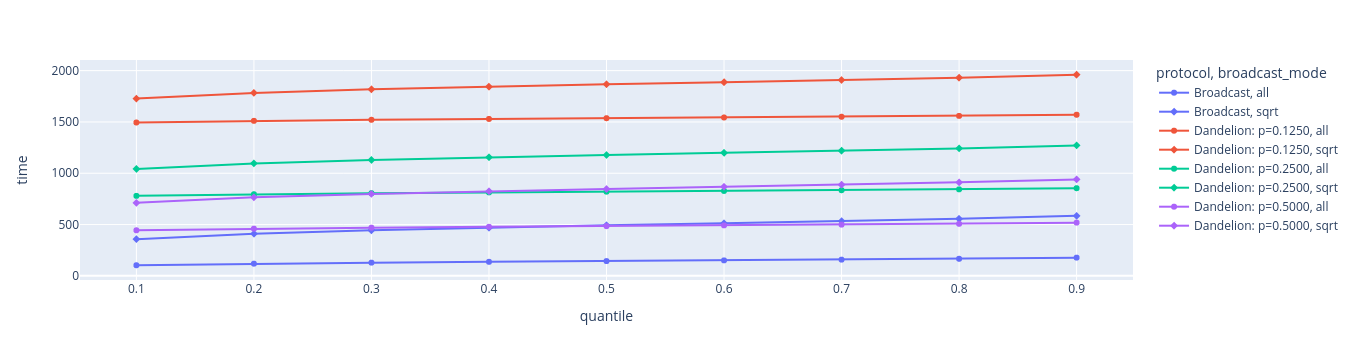

In [37]:
fig = px.line(
    visu_df, x="quantile", y="time", color="protocol", symbol="broadcast_mode"
)
fig.show()